## Simple scanning simulations

We want to use this notebook to look at some simple scanning simulations. Let's start by loading up some modules that are needed for the analysis. 

In [1]:
import os
import sys
sys.path.append('../python/')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import healpy as hp
import tools
from instrument import ScanStrategy, MPIBase, Instrument

Before starting time domain scanning simulations, we need to invoke some model of the underlying sky. For this, we pick a set of CMB power spectra as determined in the WMAP 7-year release. These spectra will be passed to the synfast module that is part of the Healpix/Healpy library.

In [3]:
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',
                 unpack=True) # Cl in uK^2
lmax=700 
ell, cls = cls[0], cls[1:]
np.random.seed(25) # make sure all MPI ranks use the same seed
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK


We also need to define some simulation parameters that describe things like what part of the sky we are looking at and what our beam looks like.

In [4]:

mmax=5 
fwhm=40
ra0=[-10, 0] 
dec0=[-57.5, 0]
az_throw=50 
scan_speed=1 
rot_period=0
hwp_mode='continuous'
mlen = 24 * 60 * 60 # mission length

Now that we have defined some fundamental aspects of our simulation, we can start to think about the beams/detectors that we want to use to scan the sky.

In [5]:
b2 = ScanStrategy(mlen, # mission duration in sec.
                  sample_rate=12.01, # sample rate in Hz
                  location='spole') # Instrument at south pole 

# Create a 3 x 3 square grid of Gaussian beams
b2.create_focal_plane(nrow=3, ncol=3, fov=5, 
                      lmax=lmax, fwhm=fwhm)

# calculate tods in two chunks
chunks = b2.partition_mission(0.5*b2.mlen*b2.fsamp) 

# Allocate and assign parameters for mapmaking
b2.allocate_maps(nside=256)

# set instrument rotation
b2.set_instr_rot(period=rot_period, angles=[68, 113, 248, 293])

# Set HWP rotation
if hwp_mode == 'continuous':
    b2.set_hwp_mod(mode='continuous', freq=1.)
elif hwp_mode == 'stepped':
    b2.set_hwp_mod(mode='stepped', freq=1/(3*60*60.))

Now it is time to actually scan the sky.

In [6]:
# Generate timestreams, bin them and store as attributes
b2.scan_instrument_mpi(alm, verbose=1, ra0=ra0,
                       dec0=dec0, az_throw=az_throw, 
                       nside_spin=256)
# Solve for the maps
maps, cond = b2.solve_for_map()

Scanning with 3 x 3 grid of detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-518831
[rank 000]:	Working on chunk 001: samples 518832-1037663
[rank 000]: working on: r001c000A, r001c000B
[rank 000]:	Working on chunk 000: samples 0-518831
[rank 000]:	Working on chunk 001: samples 518832-1037663
[rank 000]: working on: r002c000A, r002c000B
[rank 000]:	Working on chunk 000: samples 0-518831
[rank 000]:	Working on chunk 001: samples 518832-1037663
[rank 000]: working on: r000c001A, r000c001B
[rank 000]:	Working on chunk 000: samples 0-518831
[rank 000]:	Working on chunk 001: samples 518832-1037663
[rank 000]: working on: r001c001A, r001c001B
[rank 000]:	Working on chunk 000: samples 0-518831
[rank 000]:	Working on chunk 001: samples 518832-1037663
[rank 000]: working on: r002c001A, r002c001B
[rank 000]:	Working on chunk 000: samples 0-518831
[rank 000]:	Working on chunk 001: samples 518832-1037663
[rank 000]: working on: r000c002A, r000c002B

With the data generated and binned into maps, we can start to visualize the results.

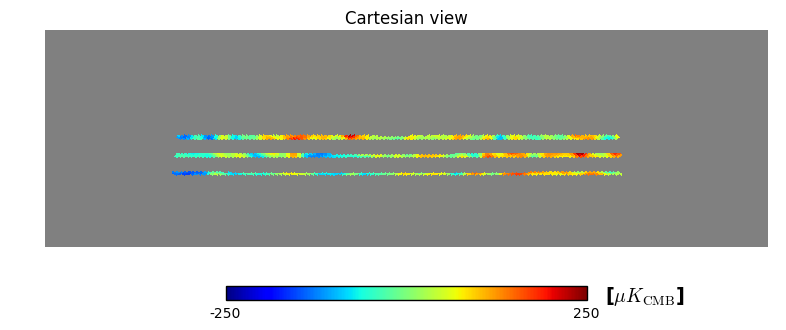

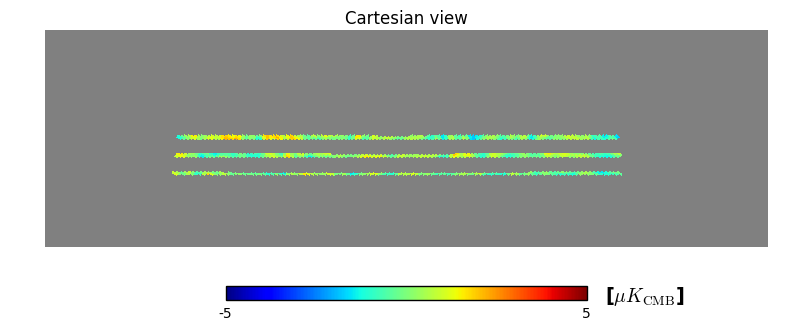

In [28]:
cond[cond == np.inf] = hp.UNSEEN
cart_opts = dict(unit=r'[$\mu K_{\mathrm{CMB}}$]')
hp.cartview(maps[0], min=-250, max=250, lonra=[-60, 40], latra=[-70, -40], **cart_opts)
hp.cartview(maps[1], min=-5, max=5, lonra=[-60, 40], latra=[-70, -40],  **cart_opts)